In [118]:
# Load packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [119]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_wrds'

# set path as working directory:
os.chdir(path)

In [120]:
# load fredgraph data:
aggregates = pd.read_csv('fredgraph.csv')

# rename some variables
aggregates.rename(columns = {'DATE':'Date', 
                             'NGDPSAXDCUSQ': 'Nominal GDP', 
                             'CPIAUCSL_NBD19840101': 'CPI',
                             'GDPDEF': 'Deflator'}, inplace = True)

# drop the first row:
aggregates = aggregates.iloc[1:,:]

# for all entries with '.' substitute with NaN:
aggregates = aggregates.replace('.', np.nan)

# make 'Deflator' and 'Nominal GDP' floats:
aggregates['Deflator'] = aggregates['Deflator'].astype(float)
aggregates['Nominal GDP'] = aggregates['Nominal GDP'].astype(float)
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'].astype(float)
aggregates['CPI'] = aggregates['CPI'].astype(float)

# make 'Date' a datetime object:
aggregates['Date'] = pd.to_datetime(aggregates['Date'])

# create 'Real GDP' variable:
aggregates['Real GDP'] = aggregates['Nominal GDP'] / aggregates['CPI'] * 100

# adjust the FF rate: 
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'] / 100
aggregates['Date'] = aggregates['Date'] - pd.DateOffset(days = 1)

In [121]:
# compute the growth rate of Nominal GDP and the Deflator:
aggregates['Growth Rate Nominal GDP'] = aggregates['Nominal GDP'].pct_change(fill_method=None)
aggregates['Growth Rate Deflator'] = aggregates['Deflator'].pct_change(fill_method=None)

# compute the growth rate of Real GDP by subtracting the growth rate of the Deflator from the growth rate of Nominal GDP:
aggregates['Growth Rate Real GDP'] = aggregates['Growth Rate Nominal GDP'] - aggregates['Growth Rate Deflator']

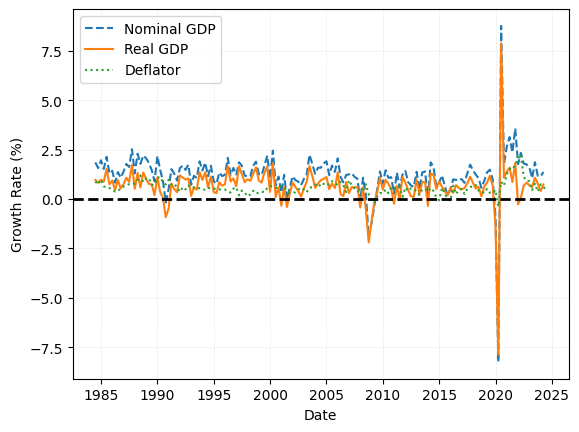

In [122]:
# plot the growth rates of Nominal GDP, Real GDP, and the Deflator:
fig, ax = plt.subplots()
ax.plot(aggregates['Date'], aggregates['Growth Rate Nominal GDP']*100, label = 'Nominal GDP', linestyle='--')
ax.plot(aggregates['Date'], aggregates['Growth Rate Real GDP']*100, label = 'Real GDP', linestyle='-')
ax.plot(aggregates['Date'], aggregates['Growth Rate Deflator']*100, label = 'Deflator', linestyle=':')
ax.set_xlabel('Date')
ax.set_ylabel('Growth Rate (%)')
# set a line at 0:
ax.axhline(0, color='black', linewidth=2, linestyle='--')
ax.legend()
ax.grid(linestyle='--', linewidth=0.5, color='lightgrey', alpha=0.5)
plt.show()

In [123]:
# load call reports data:
loans = pd.read_csv('loans_balanced_panel.csv', low_memory=False)
int_income = pd.read_csv('interest_income_balanced.csv', low_memory=False)
deposits = pd.read_csv('deposits_balanced_panel.csv', low_memory=False)

# drop duplicates from 'deposits':
deposits = deposits.drop_duplicates()

# merge the datasets
df = pd.merge(loans[['Date', 'IDRSSD', 'RCON2122', 'Flag']], deposits, 
              on=['IDRSSD', 'Date'], how='outer', suffixes=('_RCON', '_RIAD'))

# adjust the dates
df['Date'] = pd.to_datetime(df['Date'])

# create a 'Flag' that is zero if both are zero, and 1 if either is 1:
df['Flag'] = np.where(df['Flag_RCON'] + df['Flag_RIAD'] > 0, 1, 0)

# drop the two flag columns:
df = df.drop(columns=['Flag_RCON', 'Flag_RIAD'])

# drop the RSSDID of banks with Flag = 1:
banks_flag = df[df['Flag']==1]['IDRSSD'].unique()
df = df[~df['IDRSSD'].isin(banks_flag)]


# create an 'Agg. Loans' summing all the loans in a given Date:
df['Agg. Loans'] = df.groupby('Date')['RCON2122'].transform('sum')
df['Agg. Deposits'] = df.groupby('Date')['RCON2200'].transform('sum')

In [124]:
# merge df with aggregates:
df = pd.merge(df[['Date', 'IDRSSD', 'Agg. Loans', 
                  'Agg. Deposits', 'Flag']], aggregates[['Date', 'FEDFUNDS', 'Real GDP', 'Deflator', 'CPI']], on='Date', how='left')

# create aggregate real loans and deposits:
df['Agg. Real Loans'] = df['Agg. Loans'] / df['CPI'] *100
df['Agg. Real Deposits'] = df['Agg. Deposits'] / df['CPI'] *100

In [ ]:
HP = 0

if HP == 1:

    # De-trend the variables using an HP filter:
    df['De-trended Real Loans'] = sm.tsa.filters.hpfilter(np.log(df['Agg. Real Loans']), lamb=1600)[0]
    df['De-trended Real GDP'] = sm.tsa.filters.hpfilter(np.log(df['Real GDP']), lamb=1600)[0]
    df['De-trended Real Deposits'] = sm.tsa.filters.hpfilter(np.log(df['Agg. Real Deposits']), lamb=1600)[0]

else:
    # create a 'Time' variable grouping 'Dates':
    df['Time'] = df.groupby('Date').ngroup()

    # run regressions to detrend variables of interest 
    df['De-trended Real Loans'] = sm.OLS(np.log(df['Agg. Real Loans']), sm.add_constant(df['Time'])).fit().resid
    df['De-trended Real Deposits'] = sm.OLS(np.log(df['Agg. Real Deposits']), sm.add_constant(df['Time'])).fit().resid
    df['De-trended Real GDP'] = sm.OLS(np.log(df['Real GDP']), sm.add_constant(df['Time'])).fit().resid

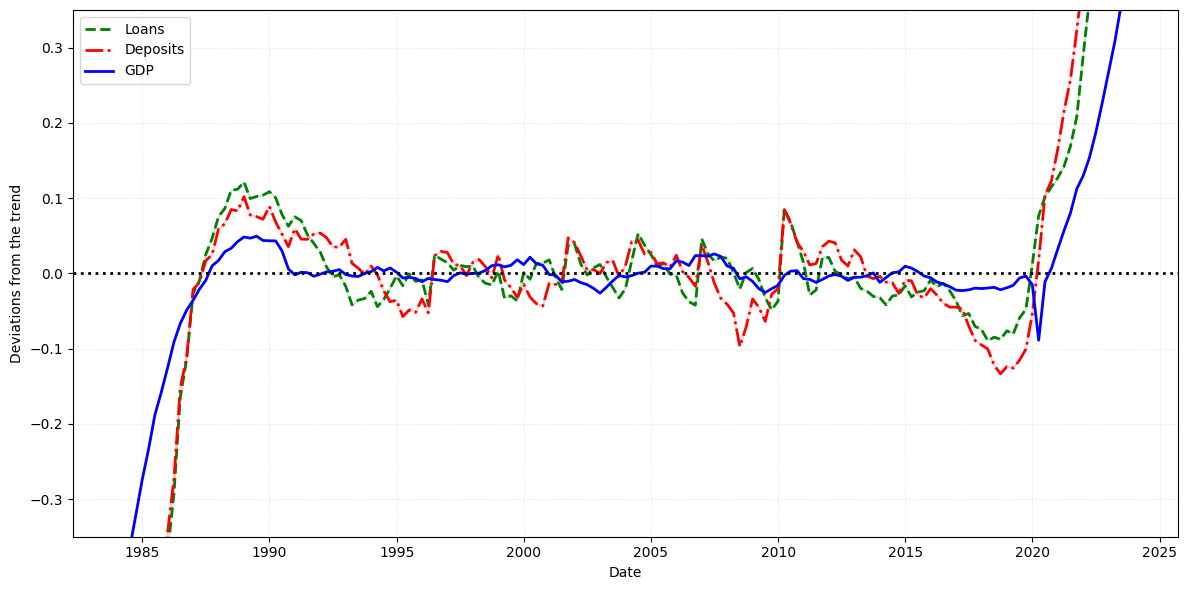

In [129]:
# plot the de-trended loans using seaborn:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='De-trended Real Loans', data=df, linewidth=2, label='Loans', color='green', linestyle='--')
sns.lineplot(x='Date', y='De-trended Real Deposits', data=df, linewidth=2, label='Deposits', color='red', linestyle='-.')
sns.lineplot(x='Date', y='De-trended Real GDP', data=df, linewidth=2, label='GDP', color='blue')
#sns.lineplot(x='Date', y='FEDFUNDS', data=df, linewidth=2, label='FF Rate', color='black', linestyle='--')
# add a line at zero:
plt.axhline(y=0, color='black', linestyle=':', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Deviations from the trend')
plt.legend()
plt.ylim(-0.35, 0.35)
plt.tight_layout()
# add the grids:
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()